<a href="https://colab.research.google.com/github/hyunseo318/ESAA_study/blob/main/%EB%B0%A9%ED%95%99%EC%8A%A4%ED%84%B0%EB%94%94_%EC%95%88%EC%A0%84%EC%9A%B4%EC%A0%84%EC%9E%90%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **8. 안전 운전자 예측**
https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

포르투 세구로 보험사에서 제공한 고객 데이터를 활용해 운전자가 보험을 청구할 확률 예측

- 문제 유형 : 이진분류
- 평가 지표 : 정규화된 지니계수
- 모델 : LightGBM과 XGBoost의 앙상블

##**8.1 경진대회 이해**
사고를 낼 가능성이 낮은 안전 운전자 : 보험료를 적게 청구

사고 가능성이 높은 난폭 운전자 : 보험료를 많이 청구

운전자가 보험금을 청구할 확률을 정확히 예측하는 모델을 만들어야 함

##**8.2 탐색적 데이터 분석**

###**8.2.1 데이터 둘러보기**

In [ ]:
import pandas as pd

#데이터 경로
data_path = '/content/drive/MyDrive/ESAA/study/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path +'train.csv', index_col = 'id')
test = pd.read_csv(data_path +'test.csv', index_col = 'id')
submission = pd.read_csv(data_path +'sample_submission.csv', index_col = 'id')

In [ ]:
train.shape, test.shape

((595212, 58), (892816, 57))

훈련 데이터 약 59만개, 테스트 데이터 약 89만개, 피처 57개

In [ ]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [ ]:
test.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,8,1,0,0,1,0,0,0,...,1,1,1,12,0,1,1,0,0,1
1,4,2,5,1,0,0,0,0,1,0,...,2,0,3,10,0,0,1,1,0,1
2,5,1,3,0,0,0,0,0,1,0,...,4,0,2,4,0,0,0,0,0,0
3,0,1,6,0,0,1,0,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,5,1,7,0,0,0,0,0,1,0,...,4,0,0,4,0,1,1,0,0,1


In [ ]:
submission.head()

,target
id,
0,0.0364
1,0.0364
2,0.0364
3,0.0364
4,0.0364


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

**피처명 비식별화**

`ps_[분류]_[분류별 일련번호]_[데이터종류]`
- 분류 : ind, reg, car, calc
- 데이터 종류 : bin, cat



**결측값 확인**
- `missingno` : 결측값 시각화하는 패키지
  - bar() : 결측값을 막대그래프 형태로 시각화, 막대그래프 높이가 낮을수록 결측값이 많다

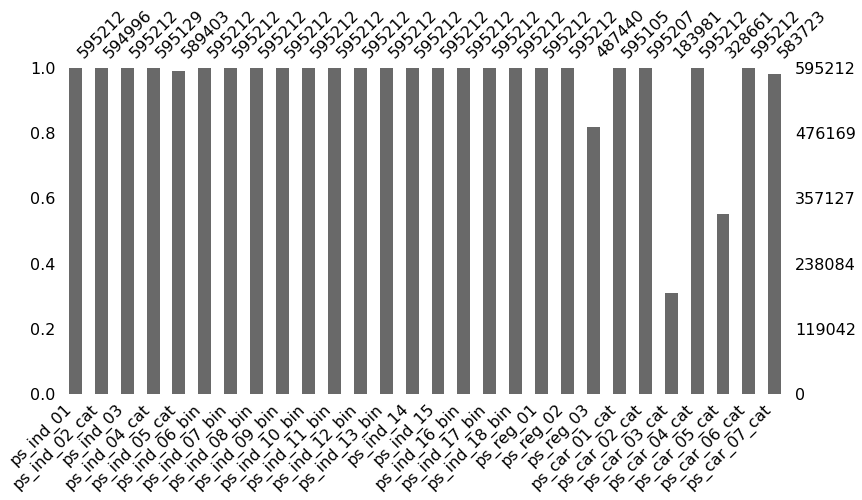

In [ ]:
import numpy as np
import missingno as msno

# 훈련 데이터 복사본에서 -1을 np.NaN로 변환
train_copy = train.copy().replace(-1,np.NaN)

# 결측값 시각화(처음 28개만)
msno.bar(df = train_copy.iloc[:,1:29] , figsize = (13,6))

ps_reg_03, ps_car_03_cat, ps_car_05_cat 에 결측값 많음

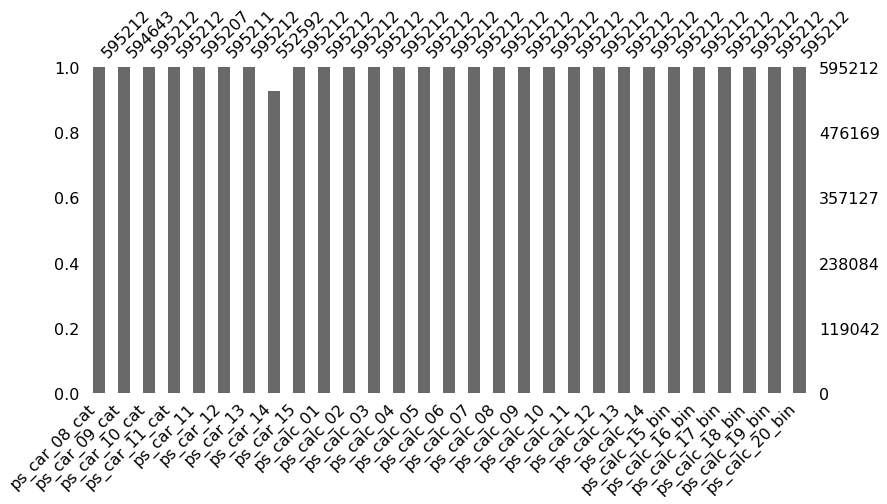

In [ ]:
msno.bar(df=train_copy.iloc[:,29:], figsize = (13,6))

ps_car_14에 결측값 있고 나머지 피처에는 거의 없음

####**결측값 매트릭스 형태로 시각화하기**
검은색으로 뾰족하게 튀어나온 부분이 결측값이 몰려있는 행을 의미

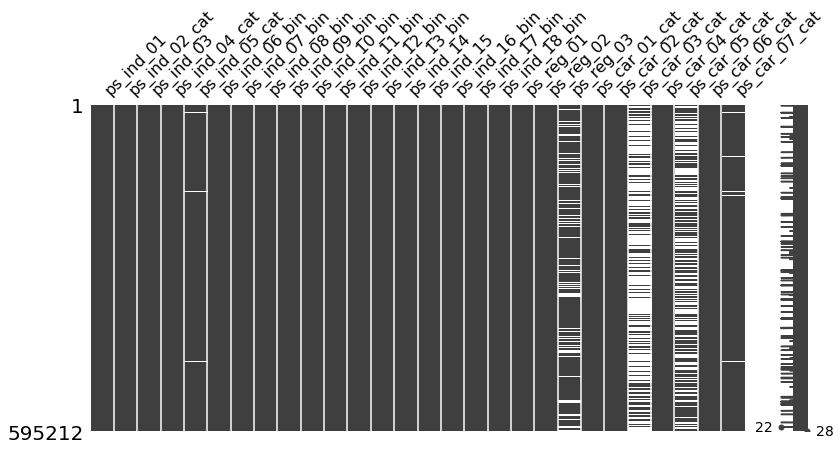

In [ ]:
msno.matrix(df=train_copy.iloc[:,1:29],figsize=(13,6))

####**피처 요약표**
- 결측값이 -1이므로 결측값 개수를 구하기 위해 피처별 -1의 개수 구함
- for 문 이용해 데이터 종류 추가

In [ ]:
def resumetable(df):
    print(f'데이터 세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary['결측값 개수'] = (df == -1).sum().values # 피처별 -1 개수
    summary['고윳값 개수'] = df.nunique().values
    summary['데이터 종류'] = None
    for col in df.columns:
        if 'bin' in col or col == 'target':
            summary.loc[col, '데이터 종류'] = '이진형'
        elif 'cat' in col:
            summary.loc[col, '데이터 종류'] = '명목형'
        elif df[col].dtype == float:
            summary.loc[col, '데이터 종류'] = '연속형'
        elif df[col].dtype == int:
            summary.loc[col, '데이터 종류'] = '순서형'

    return summary

In [ ]:
summary = resumetable(train)
summary

데이터 세트 형상: (595212, 58)


,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
target,int64,0,2,이진형
ps_ind_01,int64,0,8,순서형
ps_ind_02_cat,int64,216,5,명목형
ps_ind_03,int64,0,12,순서형
ps_ind_04_cat,int64,83,3,명목형
ps_ind_05_cat,int64,5809,8,명목형
ps_ind_06_bin,int64,0,2,이진형
ps_ind_07_bin,int64,0,2,이진형
ps_ind_08_bin,int64,0,2,이진형
ps_ind_09_bin,int64,0,2,이진형


In [ ]:
summary[summary['데이터 종류'] == '명목형'].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

In [ ]:
summary[summary['데이터 타입'] == 'float64'].index

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03'],
      dtype='object')

###**8.2.2 데이터 시각화**
모델링에 필요한 피처 선정

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

####**타깃값 분포**

타깃값이 불균형함 : 비율이 작은 타깃값 1을 잘 예측하는 것이 중요
- 고윳값마다 타깃값 비율이 다른 피처여야 모델링에 도움이 됨
- 통계적 유효성이 높아야(신뢰구간이 좁아야) 모델링에 도움이 됨


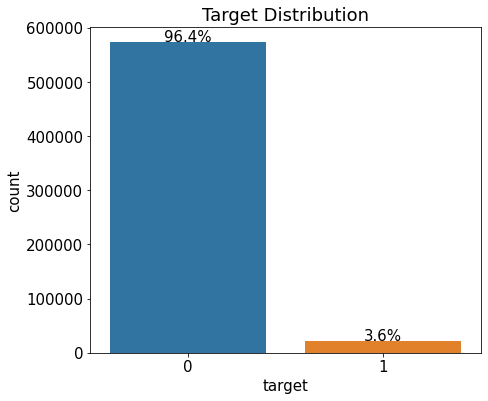

In [ ]:
def write_percent(ax, total_size):
    '''도형 객체를 순회하며 막대 그래프 상단에 타깃값 비율 표시'''
    for patch in ax.patches:
        height = patch.get_height()     # 도형 높이(데이터 개수)
        width = patch.get_width()       # 도형 너비
        left_coord = patch.get_x()      # 도형 왼쪽 테두리의 x축 위치
        percent = height/total_size*100 # 타깃값 비율
        
        # (x, y) 좌표에 텍스트 입력
        ax.text(left_coord + width/2.0,     # x축 위치
                height + total_size*0.001,  # y축 위치
                '{:1.1f}%'.format(percent), # 입력 텍스트
                ha='center')                # 가운데 정렬
    
mpl.rc('font', size=15)
plt.figure(figsize=(7, 6))

ax = sns.countplot(x='target', data=train)
write_percent(ax, len(train)) # 비율 표시
ax.set_title('Target Distribution');

####**이진 피처**

In [ ]:
import matplotlib.gridspec as gridspec

def plot_target_ratio_by_features(df, features, num_rows, num_cols, 
                                  size=(12, 18)):
    mpl.rc('font', size=9) 
    plt.figure(figsize=size)                     # 전체 Figure 크기 설정
    grid = gridspec.GridSpec(num_rows, num_cols) # 서브플롯 배치
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # 서브플롯 좌우/상하 여백 설정

    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        # ax축에 고윳값별 타깃값 1 비율을 막대 그래프로 그리기
        sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax)

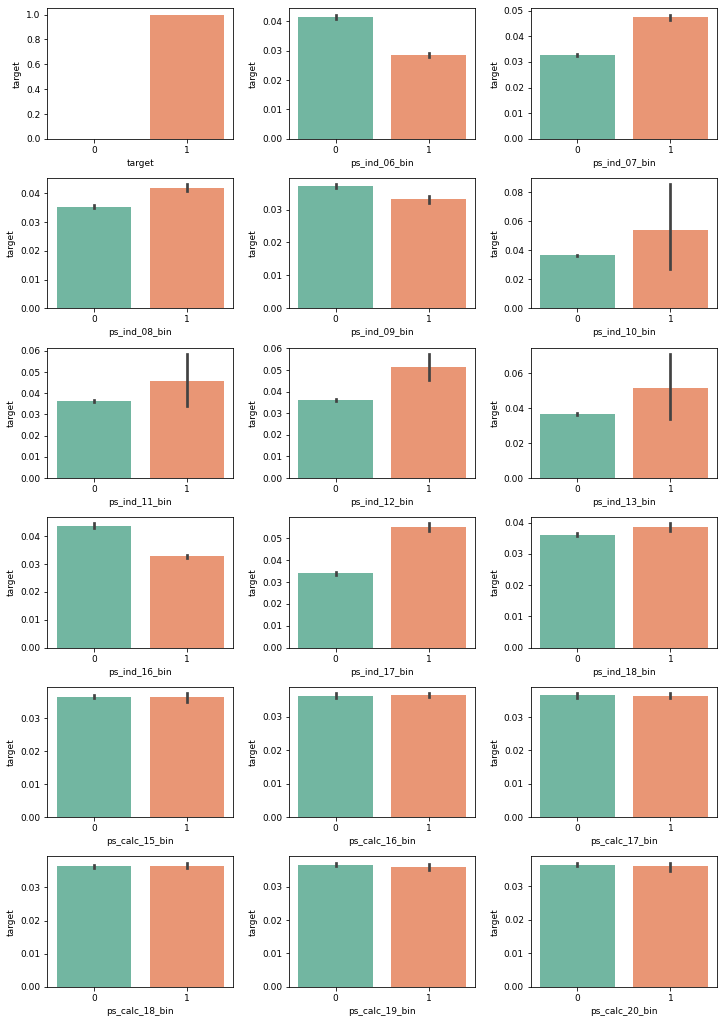

In [ ]:
bin_features = summary[summary['데이터 종류'] == '이진형'].index # 이진 피처
# 이진 피처 고윳값별 타깃값 1 비율을 막대 그래프로 그리기
plot_target_ratio_by_features(train, bin_features, 6, 3) # 6행 3열 배치


**모델링 시 제거할 피처**
- `ps_ind_10_bin~ps_ind_13_bin` : 신뢰구간이 넓어 통계적 유효성이 떨어짐
- `ps_calc_15_bin~ps_calc_20_bin` : 고윳값별 타깃값 비율 차이가 없어 타깃값 예측력이 없음
  - calc 분류의 이진 피처는 모두 타깃값 비율에 차이가 없음

####**명목형 피처**


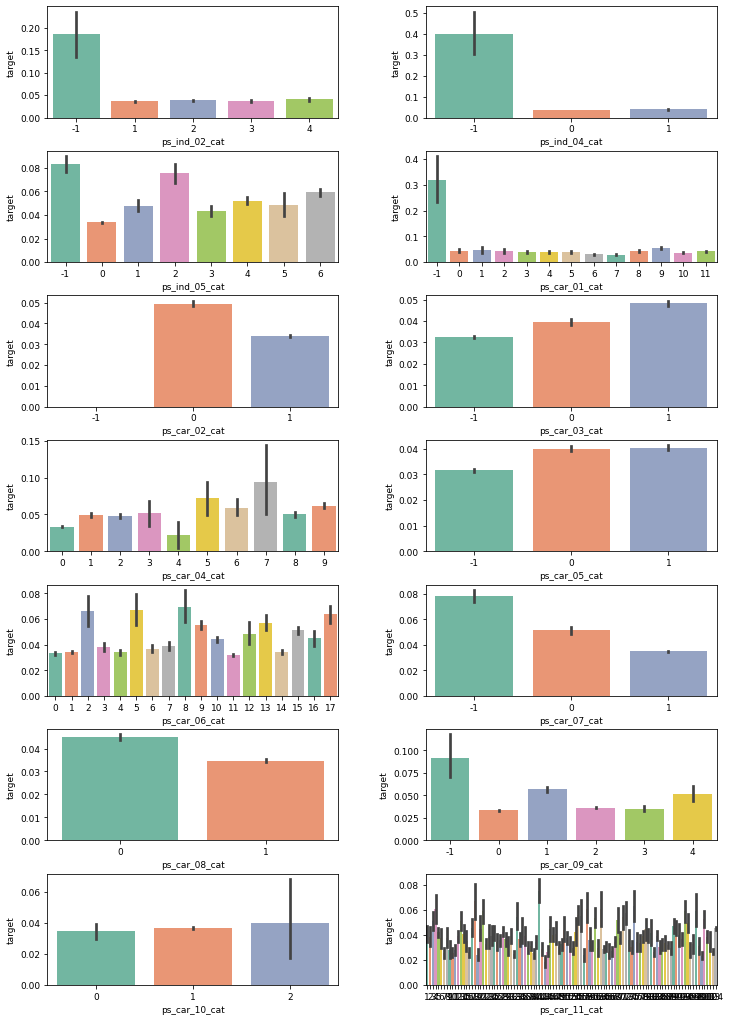

In [ ]:
nom_features = summary[summary['데이터 종류'] == '명목형'].index # 명목형 피처

plot_target_ratio_by_features(train, nom_features, 7, 2) # 7행 2열


- `ps_ind_02_cat` : 결측값 -1이 다른 고윳값들보다 타깃값 1 비율이 크다
  - 결측값 자체가 타깃값에 대한 예측력이 있으므로 처리하지 않음

- `ps_car_02_cat` : -1일 때 타깃값 1 비율은 0%
  - 피처 값이 -1이면 타깃값이 0이라고 판단해도 됨, 결측값이 타깃값을 예측하는 데 도움을 줌

- `ps_ind_02_cat, ps_ind_04_cat, ps_car_01_cat` : -1을 제외하고 나머지 고윳값은 타깃값 1 비율이 비슷하며 -1일 때의 신뢰구간이 상대적으로 넓다.
  - -1의 신뢰하한과 다른 고윳값들의 신뢰상한 간 차이가 큼
  - 고윳값 간 타깃값 1 비율에 차이가 있으므로 모델링에 필요한 피처

- `ps_car_10_cat` : 고윳값별 타깃값 1의 평균 비율이 비슷하고 고윳값 2의 신뢰구간이 유독 넓다.-- 애매한 경우
  - 제거하지 않는 것이 성능이 더 좋음(비교해보아야 함)


질문 - ps_car_10_cat 은 애매하다고 판단, 순서형 피처에서 ps_ind_14는 제거한다. -> 무슨 기준?* 

####**순서형 피처**

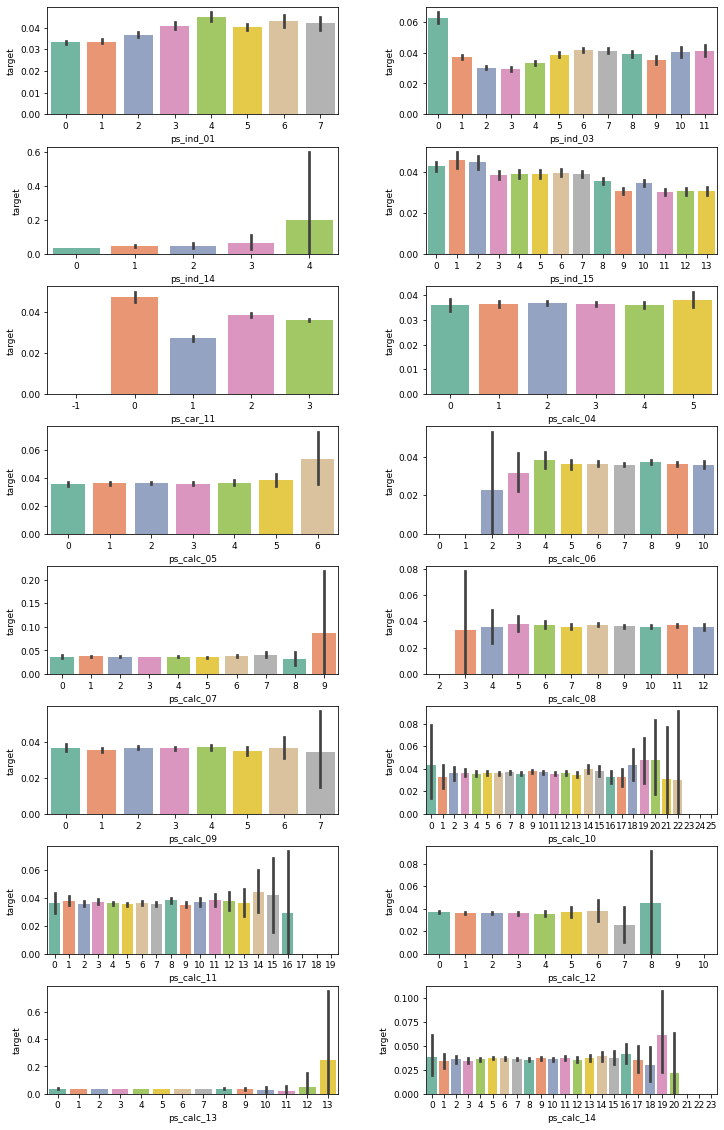

In [ ]:
ord_features = summary[summary['데이터 종류'] == '순서형'].index # 순서형 피처

plot_target_ratio_by_features(train, ord_features, 8, 2, (12, 20)) # 8행 2열


**모델링 시 제거할 피처**
- `ps_ind_14` : 고윳값 0, 1, 2, 3의 타깃값 비율은 큰 차이가 없고 고윳값 4의 신뢰구간이 넓다. 
  - 타깃값 비율의 신뢰구간이 넓어 통계적 유효성이 떨어짐
- `ps_calc_04~ps_calc_14 `
  - 고윳값별 타깃값 비율 차이가 없음. 타깃값 비율이 다르더라도 신뢰구간이 넓어 통계적 유효성이 떨어짐.

####**연속형 피처**
고윳값별 타깃값 1 비율을 구하기가 어려우므로, 몇 개의 구간으로 나누어 구간별 타깃값 1 비율을 알아봄

- `cut()` : 연속형 데이터를 범주형 데이터로 바꾸는 효과

In [ ]:
pd.cut([1.0,1.5,2.1,2.7,3.5,4.0],3)

[(0.997, 2.0], (0.997, 2.0], (2.0, 3.0], (2.0, 3.0], (3.0, 4.0], (3.0, 4.0]]
Categories (3, interval[float64, right]): [(0.997, 2.0] < (2.0, 3.0] < (3.0, 4.0]]

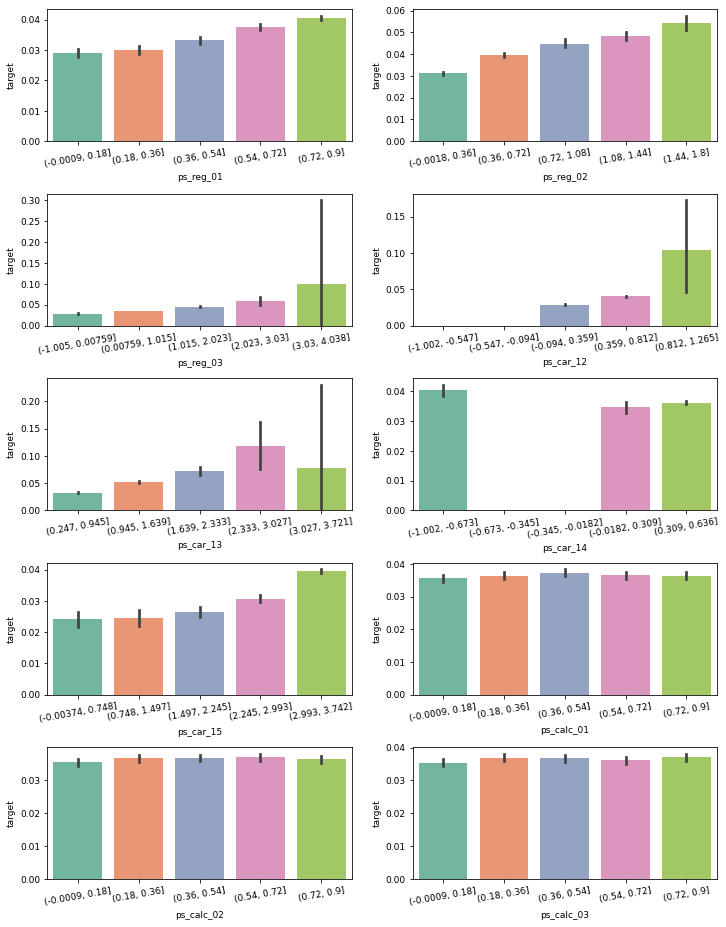

In [ ]:
cont_features = summary[summary['데이터 종류'] == '연속형'].index # 연속형 피처

plt.figure(figsize=(12, 16))                # Figure 크기 설정
grid = gridspec.GridSpec(5, 2)              # GridSpec 객체 생성
plt.subplots_adjust(wspace=0.2, hspace=0.4) # 서브플롯 간 여백 설정

for idx, cont_feature in enumerate(cont_features):
    # 값을 5개 구간으로 나누기
    train[cont_feature] = pd.cut(train[cont_feature], 5)

    ax = plt.subplot(grid[idx])                # 분포도를 그릴 서브플롯 설정
    sns.barplot(x=cont_feature, y='target', data=train, palette='Set2', ax=ax)
    ax.tick_params(axis='x', labelrotation=10) # x축 라벨 회전


**모델링 시 제거할 피처**
- `ps_calc_01~ps_calc_03` : 구간별 타깃값 비율 차이가 없음

- calc 분류의 피처는 데이터 종류에 상관없이 모두 제거해야 함

####**연속형 피처2 : 상관관계**
- 일반적으로 강한 상관관계를 보이는 두 피처가 있으면 둘 중 하나를 제거하는 것이 좋음
- 상관관계가 강하면 타깃값 예측력도 비슷함

**상관관계가 얼마나 강한 피처를 제거해야 하는가?**

|피어슨 상관계수|상관관계|
|---|---|
|0.00~0.19|아주약함|
|0.20~0.39|약함|
|0.40~0.59|보통|
|0.60~0.79|강함|
|0.80~1.0|아주 강함|

0.8 이상의 아주 강한 상관관계를 보이는 피처가 있다면 제거를 고려






In [ ]:
train_copy = train_copy.dropna() # np.NaN 값 삭제

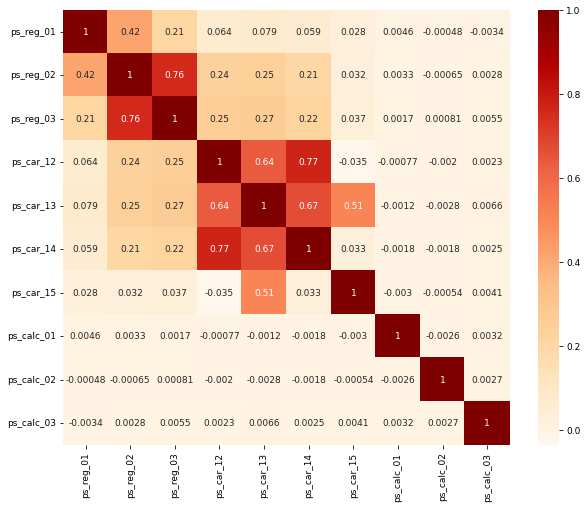

In [ ]:
plt.figure(figsize=(10, 8))
cont_corr = train_copy[cont_features].corr()     # 연속형 피처 간 상관관계 
sns.heatmap(cont_corr, annot=True, cmap='OrRd'); # 히트맵 그리기


- 가장 강한 상관관계 : `ps_car_12, ps_car_14` 0.77
  - ps_car_14 제거하니 성능이 더 좋아짐
- 두번째로 강한 상관관계 : `ps_reg_02, ps_reg_03` 0.76
  - 둘 중 하나를 제거하니 성능이 떨어짐, 그대로 남겨둠

##**8.3 베이스라인 모델**

LightGBM : 마이크로소프트가 개발한 모델, 빠르면서 성능이 좋음

In [ ]:
import pandas as pd

#데이터 경로
data_path = '/content/drive/MyDrive/ESAA/study/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path +'train.csv', index_col = 'id')
test = pd.read_csv(data_path +'test.csv', index_col = 'id')
submission = pd.read_csv(data_path +'sample_submission.csv', index_col = 'id')

###**8.3.1 피처 엔지니어링**

####**데이터 합치기**

In [ ]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1) # 타깃값 제거

In [ ]:
all_features = all_data.columns # 전체 피처
all_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

####**명목형 피처 원-핫 인코딩**


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# 명목형 피처 추출
cat_features = [feature for feature in all_features if 'cat' in feature] 

onehot_encoder = OneHotEncoder() # 원-핫 인코더 객체 생성
# 인코딩
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features]) 

encoded_cat_matrix

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

####**필요 없는 피처 제거**


In [ ]:
# 추가로 제거할 피처
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 
                 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

# '1) 명목형 피처, 2) calc 분류의 피처, 3) 추가 제거할 피처'를 제외한 피처
remaining_features = [feature for feature in all_features 
                      if ('cat' not in feature and 
                          'calc' not in feature and 
                          feature not in drop_features)]


In [ ]:
from scipy import sparse
#hstack : 행렬을 수평 방향으로 합침
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                               encoded_cat_matrix],
                              format='csr')

####**데이터 나누기**

In [ ]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

###**8.3.2 평가지표 계산 함수 작성**
정규화 지니계수 = 예측 값에 대한 지니계수 / 예측이 완벽할 때의 지니계수


In [ ]:
import numpy as np

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [ ]:
def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True # 반환값

정규화된 지니계수는 값이 클수록 모델 성능이 좋다
- 마지막 반환값 : 평가 점수가 높을수록 좋은지 여부

###**8.3.3 모델 훈련 및 성능 검증**



####**OOF 예측 방식**
K 폴드 교차 검증을 수행하면서 각 폴드마다 테스트 데이터로 예측하는 방식

K 폴드 교차 검증을 하면서 폴드마다

1) 훈련 데이터로 모델을 훈련하고
2) 검증 데이터로 모델 성능을 측정하며
3) 테스트 데이터로 최종 타깃 확률도 예측

> **예측 절차**
1. 전체 훈련 데이터를 K 개 그룹으로 나눈다.
2. K개 그룹 중 한 그룹은 검증 데이터, 나머지 K-1개 그룹은 훈련 데이터로 지정한다.
3. 훈련 데이터로 모델을 훈련한다.
4. 훈련된 모델을 이용해 검증 데이터로 타깃 확률을 예측하고, 전체 테스트 데이터로도 타깃 확률을 예측한다.
5. 검증 데이터로 구한 예측 확률과 테스트 데이터로 구한 예측 확률을 기록한다.
6. 검증 데이터를 다른 그룹으로 바꿔가며 2~5번 절차를 총 K번 반복한다.
7. K개 그룹의 검증 데이터로 예측한 확률을 훈련 데이터 실제 타깃값과 비교해 성능 평가점수를 계산한다. 이 점수로 모델 성능을 가늠해볼 수 있다.
8. ***테스트 데이터로 구한 K개 예측 확률의 평균***을 구한다. 이 값이 최종 예측 확률이며, 제출해야 하는 값이다.

***검증 데이터를 활용한 예측 확률과 훈련 데이터 실제 타깃값을 이용해 성능 평가 점수***를 도출 : 정규화 지니계수

**장점**

1) 과대 적합 방지 효과
- K 폴드 방식으로 평가하기 때문에 훈련 데이터와 검증 데이터는 서로 다르다. 
- 훈련 시 접하지 못한 데이터로 성능을 평가하기 때문에 새로운 데이터에 대한 일반화 성능이 어느 정도일지 가늠하기 쉬움

2) 앙상블 효과
- 같은 훈련 데이터셋으로 훈련한 2개 이상의 모델의 예측 겨로가를 결합하는 기법
- K개 모델로 K번 예측해 평균을 냄


####**OOF 방식으로 LightGBM 훈련**
타깃값이 불균형하기 때문에 층화 K 폴드 수행

- `n_splits` : 훈련 데이터를 나누는 폴드 수
- `shuffle=True` : 폴드를 나눌 때 데이터를 섞음

In [ ]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

In [ ]:
params = {'objective': 'binary',
          'learning_rate': 0.01,
          'force_row_wise': True, #경고 문구 없애기
          'random_state': 0}

In [ ]:
# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0]) 

In [ ]:
import lightgbm as lgb

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정 
    X_train, y_train = X[train_idx], y[train_idx] # 훈련용 데이터
    X_valid, y_valid = X[valid_idx], y[valid_idx] # 검증용 데이터

    # LightGBM 전용 데이터셋 생성 
    dtrain = lgb.Dataset(X_train, y_train) # LightGBM 전용 훈련 데이터셋
    dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM 전용 검증 데이터셋

    # LightGBM 모델 훈련 
    lgb_model = lgb.train(params=params,        # 훈련용 하이퍼파라미터
                          train_set=dtrain,     # 훈련 데이터셋
                          num_boost_round=1000, # 부스팅 반복 횟수
                          valid_sets=dvalid,    # 성능 평가용 검증 데이터셋
                          feval=gini,           # 검증용 평가지표
                          early_stopping_rounds=100, # 조기종료 조건
                          verbose_eval=100)     # 100번째마다 점수 출력
    
    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # 검증 데이터 예측 확률에 대한 정규화 지니계수 
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

######################################## 폴드 1 / 폴드 5 ########################################
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.15336	valid_0's gini: 0.261801
[200]	valid_0's binary_logloss: 0.152428	valid_0's gini: 0.275964
[300]	valid_0's binary_logloss: 0.152018	valid_0's gini: 0.282624
[400]	valid_0's binary_logloss: 0.151798	valid_0's gini: 0.286985
[500]	valid_0's binary_logloss: 0.151716	valid_0's gini: 0.288374
[600]	valid_0's binary_logloss: 0.151677	valid_0's gini: 0.288793
[700]	valid_0's binary_logloss: 0.151671	valid_0's gini: 0.288778
Early stopping, best iteration is:
[646]	valid_0's binary_logloss: 0.151673	valid_0's gini: 0.288887
폴드 1 지니계수 : 0.2888871820172969

######################################## 폴드 2 / 폴드 5 ########################################
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.153506	valid_0's gini: 0.249477
[200]	valid_0's binary_log

성능 평가점수 : logloss, gini
- logloss(로그 손실) : 이진 분류에서 LightGBM의 기본 평가 지표
- feval 파라미터에 gini 함수 계산값 전달하여 추가로 출력됨, 지니계수 기준으로 조기종료 적용

In [ ]:
print('OOF 검증 데이터 지니계수:', eval_gini(y, oof_val_preds))

OOF 검증 데이터 지니계수: 0.2804880266267947


###**8.3.4 예측 및 결과 제출**

In [ ]:
submission['target'] = oof_test_preds
submission.to_csv('submission.csv')

프라이빗 : 0.28424, 상위 48%

##**8.4 성능개선 1 : LightGBM 모델**
파생 피처 추가, 베이지안 최적화

In [ ]:
import pandas as pd

#데이터 경로
data_path = '/content/drive/MyDrive/ESAA/study/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path +'train.csv', index_col = 'id')
test = pd.read_csv(data_path +'test.csv', index_col = 'id')
submission = pd.read_csv(data_path +'sample_submission.csv', index_col = 'id')

###**8.4.1 피처 엔지니어링**


####**데이터 합치기**


In [ ]:
all_data = pd.concat([train,test],ignore_index = True)
all_data = all_data.drop('target',axis=1) # 타깃값 제거

all_features = all_data.columns # 전체 피처

####**명목형 피처 원-핫 인코딩**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# 명목형 피처
cat_features = [feature for feature in all_features if 'cat' in feature] 

# 원-핫 인코딩 적용
onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features]) 

####**파생 피처 추가**

**1. 한 데이터가 가진 결측값 개수**

In [ ]:
# '데이터 하나당 결측값 개수'를 파생 피처로 추가
all_data['num_missing'] = (all_data==-1).sum(axis=1)

In [ ]:
# 명목형 피처, calc 분류의 피처를 제외한 피처
remaining_features = [feature for feature in all_features
                      if ('cat' not in feature and 'calc' not in feature)] 
# num_missing을 remaining_features에 추가
remaining_features.append('num_missing')

**2. ind 분류의 피처 값 연결**

In [ ]:
# 분류가 ind인 피처
ind_features = [feature for feature in all_features if 'ind' in feature]

is_first_feature = True
for ind_feature in ind_features:
    if is_first_feature:
        all_data['mix_ind'] = all_data[ind_feature].astype(str) + '_'
        is_first_feature = False
    else:
        all_data['mix_ind'] += all_data[ind_feature].astype(str) + '_'

In [ ]:
all_data['mix_ind']

0          2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
1488023     0_1_6_0_0_0_1_0_0_0_0_0_0_0_2_0_0_1_
1488024    5_3_5_1_0_0_0_1_0_0_0_0_0_0_11_1_0_0_
1488025     0_1_5_0_0_1_0_0_0_0_0_0_0_0_5_0_0_1_
1488026    6_1_5_1_0_0_0_0_1_0_0_0_0_0_13_1_0_0_
1488027    7_1_4_1_0_0_0_0_1_0_0_0_0_0_12_1_0_0_
Name: mix_ind, Length: 1488028, dtype: object

**3. 명목형 피처의 고윳값별 개수를 새로운 피처로 추가**

In [ ]:
all_data['ps_ind_02_cat'].value_counts()

 1    1079327
 2     309747
 3      70172
 4      28259
-1        523
Name: ps_ind_02_cat, dtype: int64

In [ ]:
all_data['ps_ind_02_cat'].value_counts().to_dict()

{1: 1079327, 2: 309747, 3: 70172, 4: 28259, -1: 523}

In [ ]:
cat_count_features = []
for feature in cat_features+['mix_ind']:
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x: 
                                                           val_counts_dict[x])
    cat_count_features.append(f'{feature}_count')

In [ ]:
cat_count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'mix_ind_count']

질문 : 고윳값별 개수가 리스트 형태로 들어가있는건지?

**필요 없는 피처 제거**

지금까지 만들어진 피처
- `encoded_cat_matrix` : 원-핫 인코딩 된 명목형 피처
- `remaining_features` : 명목형 피처와 calc 분류의 피처를 제외한 피처들 (+num_missing)
- `cat_count_features` : mix_ind를 포함한 명목형 피처의 고윳값별 개수 파생 피처

In [ ]:
from scipy import sparse
# 필요 없는 피처들
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 
                 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

# remaining_features, cat_count_features에서 drop_features를 제거한 데이터
all_data_remaining = all_data[remaining_features+cat_count_features].drop(drop_features, axis=1)

# 데이터 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining),
                               encoded_cat_matrix],
                              format='csr')

####**데이터 나누기**


In [ ]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

In [ ]:
import numpy as np

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [ ]:
# LightGBM용 gini() 함수
def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True # 반환값

###**8.4.2 하이퍼파라미터 최적화**
베이지안 최적화 기법

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# 8:2 비율로 훈련 데이터, 검증 데이터 분리 (베이지안 최적화 수행용)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.2, 
                                                      random_state=0)

# 베이지안 최적화용 데이터셋
bayes_dtrain = lgb.Dataset(X_train, y_train)
bayes_dvalid = lgb.Dataset(X_valid, y_valid)

####**하이퍼파라미터 범위 설정**
1) 하이퍼파라미터의 범위를 점점 좁히는 방법
- 0~1 사이 0.5가 최적이라면 다시 0.5주변으로 범위를 좁혀 탐색

2) 캐글러가 설정한 하이퍼파라미터 참고

In [ ]:
# 베이지안 최적화를 위한 하이퍼파라미터 범위
param_bounds = {'num_leaves': (30, 40),
                'lambda_l1': (0.7, 0.9),
                'lambda_l2': (0.9, 1),
                'feature_fraction': (0.6, 0.7),
                'bagging_fraction': (0.6, 0.9),
                'min_child_samples': (6, 10),
                'min_child_weight': (10, 40)}

# 값이 고정된 하이퍼파라미터
fixed_params = {'objective': 'binary',
                'learning_rate': 0.005,
                'bagging_freq': 1,
                'force_row_wise': True,
                'random_state': 1991}

####**베이지안 최적화용 평가지표 계산 함수**

In [ ]:
def eval_function(num_leaves, lambda_l1, lambda_l2, feature_fraction,
                  bagging_fraction, min_child_samples, min_child_weight):
    '''최적화하려는 평가지표(지니계수) 계산 함수'''
    
    # 베이지안 최적화를 수행할 하이퍼파라미터 
    params = {'num_leaves': int(round(num_leaves)),
              'lambda_l1': lambda_l1,
              'lambda_l2': lambda_l2,
              'feature_fraction': feature_fraction,
              'bagging_fraction': bagging_fraction,
              'min_child_samples': int(round(min_child_samples)),
              'min_child_weight': min_child_weight,
              'feature_pre_filter': False}
    # 고정된 하이퍼파라미터도 추가
    params.update(fixed_params)
    
    print('하이퍼파라미터:', params)    
    
    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=params, 
                           train_set=bayes_dtrain,
                           num_boost_round=2500,
                           valid_sets=bayes_dvalid,
                           feval=gini,
                           early_stopping_rounds=300,
                           verbose_eval=False)
    # 검증 데이터로 예측 수행
    preds = lgb_model.predict(X_valid) 
    # 지니계수 계산
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')
    
    return gini_score

####**최적화 수행**


In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bayes_opt import BayesianOptimization

# 베이지안 최적화 객체 생성
optimizer = BayesianOptimization(f=eval_function,      # 평가지표 계산 함수
                                 pbounds=param_bounds, # 하이퍼파라미터 범위
                                 random_state=0)

In [ ]:
# 베이지안 최적화 수행
optimizer.maximize(init_points=3, n_iter=6)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | min_ch... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
하이퍼파라미터: {'num_leaves': 30, 'lambda_l1': 0.7529111224209254, 'lambda_l2': 0.9774233689434216, 'feature_fraction': 0.6414661939990524, 'bagging_fraction': 0.7565544965250215, 'min_child_samples': 8, 'min_child_weight': 27.053018466059456, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 1991}
지니계수 : 0.283932376637082

| 3         | 0.2839    | 0.7566    | 0.6415    | 0.7529    | 0.9774    | 7.825     | 27.05     | 30.19     |
하이퍼파라미터: {'num_leaves': 34, 'lambda_l1': 0.8233867993749514, 'lambda_l2': 0.9943748078514624, 'feature_fraction': 0.6612095722722421, 'bagging_fraction': 0.7852906491227631, 'min_child_samples': 9, 'min_child_weight': 20.785237017213582, 'feature_pre_filter': False

####**결과 확인**


In [27]:
# 평가함수 점수가 최대일 때 하이퍼파라미터
max_params = optimizer.max['params']
max_params

{'bagging_fraction': 0.6675659367709144,
 'feature_fraction': 0.6952194054160209,
 'lambda_l1': 0.829932662510154,
 'lambda_l2': 0.9309382272206734,
 'min_child_samples': 7.8802172313670225,
 'min_child_weight': 28.604068940720285,
 'num_leaves': 31.937139259095634}

In [28]:
# 정수형 하이퍼파라미터 변환
max_params['num_leaves'] = int(round(max_params['num_leaves']))
max_params['min_child_samples'] = int(round(max_params['min_child_samples']))

In [29]:
# 값이 고정된 하이퍼파라미터 추가
max_params.update(fixed_params)

In [30]:
max_params

{'bagging_fraction': 0.6675659367709144,
 'feature_fraction': 0.6952194054160209,
 'lambda_l1': 0.829932662510154,
 'lambda_l2': 0.9309382272206734,
 'min_child_samples': 8,
 'min_child_weight': 28.604068940720285,
 'num_leaves': 32,
 'objective': 'binary',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'force_row_wise': True,
 'random_state': 1991}

###**8.4.3 모델 훈련 및 성능 검증**

In [ ]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기 생성
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0]) 

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx] # 훈련용 데이터
    X_valid, y_valid = X[valid_idx], y[valid_idx] # 검증용 데이터

    # LightGBM 전용 데이터셋 생성
    dtrain = lgb.Dataset(X_train, y_train) # LightGBM 전용 훈련 데이터셋
    dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM 전용 검증 데이터셋
                          
    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=max_params,    # 최적 하이퍼파라미터
                          train_set=dtrain,     # 훈련 데이터셋
                          num_boost_round=2500, # 부스팅 반복 횟수
                          valid_sets=dvalid,    # 성능 평가용 검증 데이터셋
                          feval=gini,           # 검증용 평가지표
                          early_stopping_rounds=300, # 조기종료 조건
                          verbose_eval=100)     # 100번째마다 점수 출력
    
    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # 검증 데이터 예측확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

In [ ]:
print('OOF 검증 데이터 지니계수 :', eval_gini(y, oof_val_preds))

###**8.4.4 예측 및 결과 제출**

In [ ]:
submission['target'] = oof_test_preds
submission.to_csv('submission.csv')

프라이빗 0.28424, 퍼블릭 0.27929, 23등

##**8.5 성능개선 2 : XGBoost 모델**
**수정사항**
1. 지니계수 반환값
2. 데이터셋 객체
3. 모델 하이퍼파라미터명

In [2]:
import pandas as pd

#데이터 경로
data_path = '/content/drive/MyDrive/ESAA/study/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path +'train.csv', index_col = 'id')
test = pd.read_csv(data_path +'test.csv', index_col = 'id')
submission = pd.read_csv(data_path +'sample_submission.csv', index_col = 'id')

###**8.5.1 피처 엔지니어링**

####**데이터 합치기**

In [3]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1) # 타깃값 제거

all_features = all_data.columns # 전체 피처

####**명목형 피처 원-핫 인코딩**

In [4]:
from sklearn.preprocessing import OneHotEncoder

# 명목형 피처
cat_features = [feature for feature in all_features if 'cat' in feature]

# 원-핫 인코딩 적용
onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features]) 

####**파생 피처 추가**

In [5]:
# '데이터 하나당 결측값 개수'를 파생 피처로 추가
all_data['num_missing'] = (all_data==-1).sum(axis=1)

In [6]:
# 명목형 피처, calc 분류 피처를 제외한 피처
remaining_features = [feature for feature in all_features
                      if ('cat' not in feature and 'calc' not in feature)] 
# num_missing을 remaining_features에 추가
remaining_features.append('num_missing')

In [7]:
# 분류가 ind인 피처
ind_features = [feature for feature in all_features if 'ind' in feature]

is_first_feature = True
for ind_feature in ind_features:
    if is_first_feature:
        all_data['mix_ind'] = all_data[ind_feature].astype(str) + '_'
        is_first_feature = False
    else:
        all_data['mix_ind'] += all_data[ind_feature].astype(str) + '_'

In [8]:
cat_count_features = []
for feature in cat_features+['mix_ind']:
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x: 
                                                           val_counts_dict[x])
    cat_count_features.append(f'{feature}_count')

####**필요 없는 피처 제거**

In [9]:
from scipy import sparse

# 필요 없는 피처들
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 
                 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

# remaining_features, cat_count_features에서 drop_features를 제거한 데이터
all_data_remaining = all_data[remaining_features+cat_count_features].drop(drop_features, axis=1)

# 데이터 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining),
                               encoded_cat_matrix],
                              format='csr')

####**데이터 나누기**

In [10]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

####**정규화 지니계수 계산함수**

In [11]:
import numpy as np

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [12]:
# XGBoost용 gini() 함수
def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds)

###**8.5.2 하이퍼파라미터 최적화**

####**데이터셋 준비**

In [13]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 8:2 비율로 훈련 데이터, 검증 데이터 분리 (베이지안 최적화 수행용)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.2, 
                                                      random_state=0)
# 베이지안 최적화용 데이터셋
bayes_dtrain = xgb.DMatrix(X_train, y_train)
bayes_dvalid = xgb.DMatrix(X_valid, y_valid)

####**하이퍼파라미터 범위 설정**

In [14]:
# 베이지안 최적화를 위한 하이퍼파라미터 범위
param_bounds = {'max_depth': (4, 8),
                'subsample': (0.6, 0.9),
                'colsample_bytree': (0.7, 1.0),
                'min_child_weight': (5, 7),
                'gamma': (8, 11),
                'reg_alpha': (7, 9),
                'reg_lambda': (1.1, 1.5),
                'scale_pos_weight': (1.4, 1.6)}

# 값이 고정된 하이퍼파라미터
fixed_params = {'objective': 'binary:logistic',
                'learning_rate': 0.02,
                'random_state': 1991}

####**베이지안 최적화용 평가지표 계산 함수**

In [15]:
def eval_function(max_depth, subsample, colsample_bytree, min_child_weight,
                 reg_alpha, gamma, reg_lambda, scale_pos_weight):
    '''최적화하려는 평가지표(지니계수) 계산 함수'''
    # 베이지안 최적화를 수행할 하이퍼파라미터
    params = {'max_depth': int(round(max_depth)),
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'min_child_weight': min_child_weight,
              'gamma': gamma,
              'reg_alpha':reg_alpha,
              'reg_lambda': reg_lambda,
              'scale_pos_weight': scale_pos_weight}
    # 값이 고정된 하이퍼파라미터도 추가
    params.update(fixed_params)
    
    print('하이퍼파라미터 :', params)    
        
    # XGBoost 모델 훈련
    xgb_model = xgb.train(params=params, 
                          dtrain=bayes_dtrain,
                          num_boost_round=2000,
                          evals=[(bayes_dvalid, 'bayes_dvalid')],
                          maximize=True,
                          feval=gini,
                          early_stopping_rounds=200,
                          verbose_eval=False)
                           
    best_iter = xgb_model.best_iteration # 최적 반복 횟수
    # 검증 데이터로 예측 수행
    preds = xgb_model.predict(bayes_dvalid, 
                              iteration_range=(0, best_iter))
    # 지니계수 계산
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')
    
    return gini_score

####**최적화 수행**

In [ ]:
from bayes_opt import BayesianOptimization

# 베이지안 최적화 객체 생성
optimizer = BayesianOptimization(f=eval_function, 
                                 pbounds=param_bounds, 
                                 random_state=0)

# 베이지안 최적화 수행
optimizer.maximize(init_points=3, n_iter=6)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
하이퍼파라미터 : {'max_depth': 6, 'subsample': 0.867531900234624, 'colsample_bytree': 0.8646440511781974, 'min_child_weight': 6.0897663659937935, 'gamma': 10.14556809911726, 'reg_alpha': 7.84730959867781, 'reg_lambda': 1.3583576452266626, 'scale_pos_weight': 1.4875174422525386, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


####**결과 확인**

In [ ]:
# 평가함수 점수가 최대일 때 하이퍼파라미터
max_params = optimizer.max['params']
max_params

In [ ]:
# 정수형 하이퍼파라미터 변환
max_params['max_depth'] = int(round(max_params['max_depth']))

# 값이 고정된 하이퍼파라미터 추가
max_params.update(fixed_params)
max_params

###**8.5.3 모델 훈련 및 성능 검증**

In [ ]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기 생성
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0]) 

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    # XGBoost 전용 데이터셋 생성 
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    dtest = xgb.DMatrix(X_test)
    # XGBoost 모델 훈련
    xgb_model = xgb.train(params=max_params, 
                          dtrain=dtrain,
                          num_boost_round=2000,
                          evals=[(dvalid, 'valid')],
                          maximize=True,
                          feval=gini,
                          early_stopping_rounds=200,
                          verbose_eval=100)

    # 모델 성능이 가장 좋을 때의 부스팅 반복 횟수 저장
    best_iter = xgb_model.best_iteration
    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds += xgb_model.predict(dtest,
                                        iteration_range=(0, best_iter))/folds.n_splits
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds[valid_idx] += xgb_model.predict(dvalid, 
                                                  iteration_range=(0, best_iter))
    
    # 검증 데이터 예측 확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')


In [ ]:
print('OOF 검증 데이터 지니계수 :', eval_gini(y, oof_val_preds))

###**8.5.4 예측 및 결과 제출**

In [ ]:
submission['target'] = oof_test_preds
submission.to_csv('submission.csv')

##**8.6 성능개선 3 : LightGBM과 XGBoost 앙상블**

###**8.6.1 앙상블 수행**

LightGBM으로 예측한 확률값 = oof_test_preds_lgb

XGBoost로 예측한 확률값 = oof_test_preds_xgb

50%가중치를 주어 구한 가중평균

In [ ]:
oof_test_preds = oof_test_preds_lgb *0.5 + oof_test_preds_xgb *0.5

###**8.6.2 예측 및 결과 제출**

In [ ]:
submission['target'] = oof_test_preds
submission.to_csv('submission.csv')